In [27]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier, Pool, cv
from lib import preprocess
import optuna
from tqdm import tqdm

# Load Preprocessed Data

[<span style="color:red">Info</span>]Run '*process_data.ipynb*' to generate the required data.

In [28]:
path_data = Path("../data")
train = pd.read_pickle(path_data / "train_prep.pkl")
test = pd.read_pickle(path_data / "test_prep.pkl")

categorical_columns = pd.read_pickle(path_data / "categorical_columns.pkl")
numerical_columns = pd.read_pickle(path_data / "numerical_columns.pkl")


# Train Catboost

In [29]:
# Convert categorical columns to strings to avoid CatBoost errors
for col in categorical_columns:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)


# Prepare data
X = train.drop(columns=["Depression"])
y = train["Depression"]
X_test = test

# Initialize arrays to store out-of-fold predictions and test predictions
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

# Stratified K-Fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

with tqdm(total=n_splits, desc="Folds") as pbar:
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # Create Pool objects for CatBoost with categorical columns only
        train_pool = Pool(
            data=X_train_fold,
            label=y_train_fold,
            cat_features=categorical_columns,
        )
        val_pool = Pool(
            data=X_val_fold,
            label=y_val_fold,
            cat_features=categorical_columns,
        )

        # Initialize and train the model
        model = CatBoostClassifier(
            iterations=1000,
            learning_rate=0.1,
            depth=6,
            loss_function="Logloss",
            eval_metric="Accuracy",
            random_seed=42,
            logging_level="Silent",
        )
        model.fit(train_pool, eval_set=val_pool)

        # Predict on validation fold
        oof_preds[val_idx] = model.predict_proba(val_pool)[:, 1]

        # Predict on test set and accumulate predictions
        test_pool = Pool(
            data=X_test,
            cat_features=categorical_columns,
        )
        test_preds += model.predict_proba(test_pool)[:, 1] / n_splits

        pbar.update(1)

# Evaluate out-of-fold predictions
auc_score = roc_auc_score(y, oof_preds)
accuracy = accuracy_score(y, (oof_preds >= 0.5).astype(int))
print(f"Out-of-Fold ROC AUC: {auc_score:.4f}")
print(f"Out-of-Fold Accuracy: {accuracy:.4f}")

# Generate final predictions on test set
y_test_pred = (test_preds >= 0.5).astype(int)

# Save predictions to submission file
submission = pd.read_csv(path_data / "sample_submission.csv")
submission["Depression"] = y_test_pred
submission.to_csv(path_data / "submission.csv", index=False)
submission.head()

Folds: 100%|██████████| 5/5 [02:14<00:00, 26.97s/it]

Out-of-Fold ROC AUC: 0.9756
Out-of-Fold Accuracy: 0.9405


,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


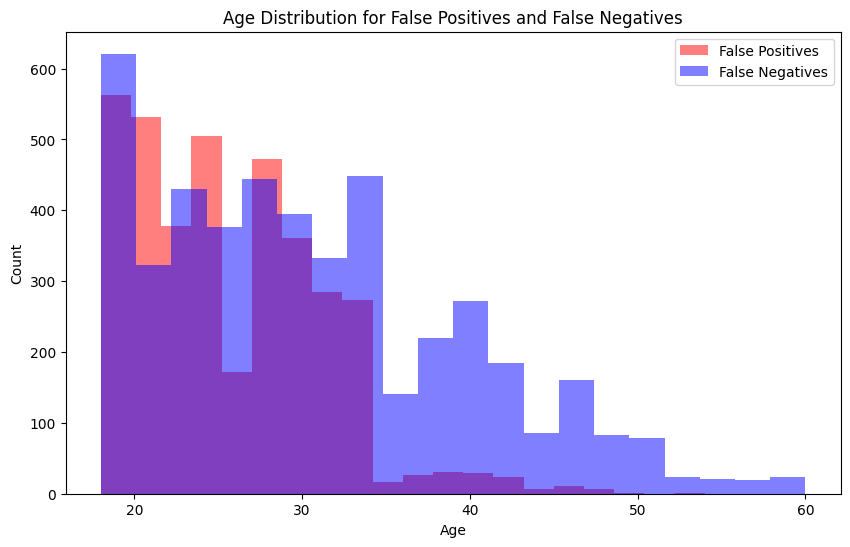

In [30]:
# Get false positive and false negative indices for 'age' column
fp_idx = (oof_preds >= 0.5) & (y == 0)
fn_idx = (oof_preds < 0.5) & (y == 1)

# Plot 'age' distribution for false positives and false negatives
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(X["Age"][fp_idx], bins=20, alpha=0.5, label="False Positives", color="red")
plt.hist(X["Age"][fn_idx], bins=20, alpha=0.5, label="False Negatives", color="blue")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend()
plt.title("Age Distribution for False Positives and False Negatives")
plt.show()

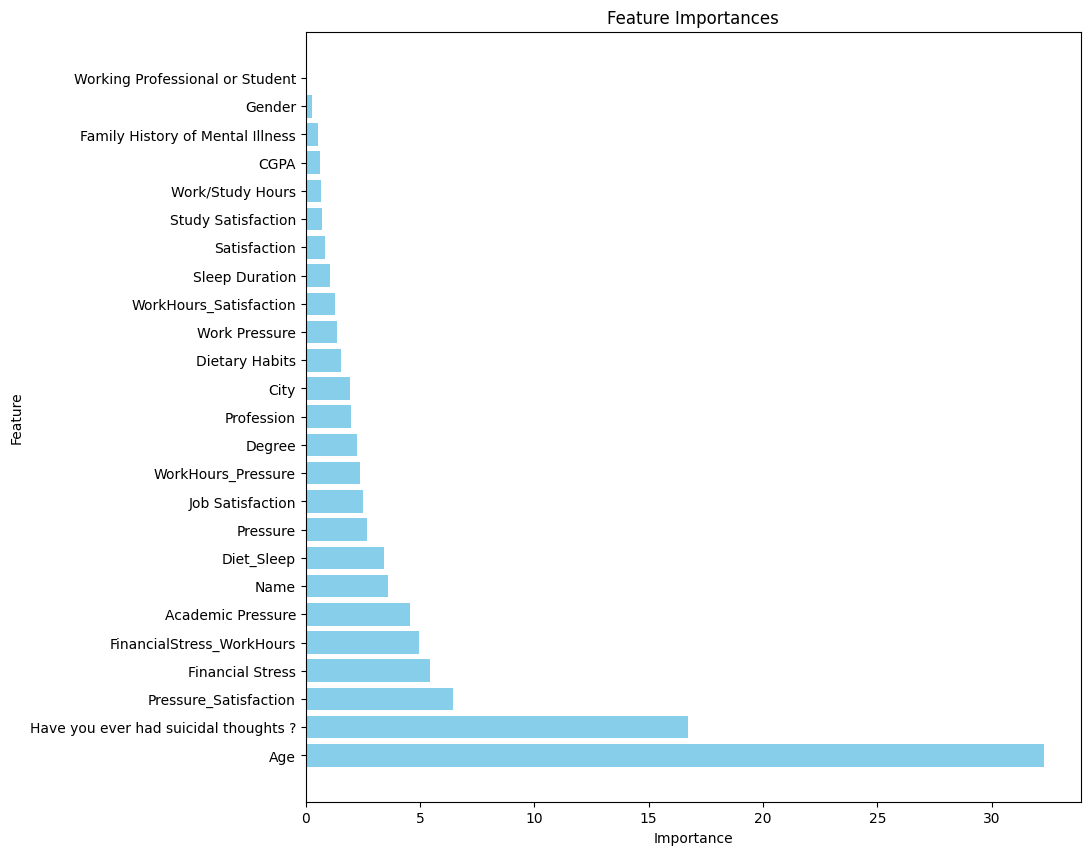

['Age' 'Have you ever had suicidal thoughts ?' 'Pressure_Satisfaction'
 'Financial Stress' 'FinancialStress_WorkHours' 'Academic Pressure' 'Name'
 'Diet_Sleep' 'Pressure' 'Job Satisfaction']


In [31]:
# Get feature importances
feature_importances = model.get_feature_importance(prettified=True)
# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

plt.barh(
    feature_importances["Feature Id"],
    feature_importances["Importances"],
    color="skyblue",
)

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")

plt.show()


# select top 10 features
top_features = feature_importances["Feature Id"][:10].values

print(top_features)

In [32]:
# Save predictions
submission = pd.read_csv(path_data / "sample_submission.csv")

submission["Depression"] = y_test_pred

submission.to_csv(path_data / "submission.csv", index=False)

submission.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
